# Running the Deutsch-Josza algorithm

For SRP\*400 in Winter 2019-2020 at Phillips Exeter Academy, by [Evan Chandran](https://github.com/ecchandran) and [Maxwell Wang](https://github.com/maxzwang).

Runs the [Deutsch-Josza algorithm](https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm) \[1\] for `n = 2` using [pyQuil](https://github.com/rigetti/pyquil) and the [Quantum Virtual Machine (QVM)](https://github.com/rigetti/qvm), and plots a histogram of the outcomes.

\[1\] David Deutsch and Richard Jozsa. (1997) Rapid solution of problems by quantum computation. _Proc. R. Soc. Lond. A_ **439**:553–558.
http://doi.org/10.1098/rspa.1992.0167

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
from pyquil import get_qc, Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import CNOT, H, MEASURE, X
from pyquil.latex import display

## Choose parameters

Each time this cell is run, a random `oracle_id` is selected, which picks a particular binary function in the `oracle_dict`.

In [2]:
n = 2  # currently only works for n = 2
num_shots = 1000  # the number of times to run the quantum circuit

oracle_dict = {0: 'constant_0', 1: 'constant_1',
               2: 'balanced_XOR', 3: 'balanced_NOT_XOR',
               4: 'balanced_X1', 5: 'balanced_NOT_X1',
               6: 'balanced_X0', 7: 'balanced_NOT_X0'}

oracle_id = random.randrange(8)

## Build the pyQuil `Program`

In [3]:
p = Program()
ro = p.declare('ro', 'BIT', n)

# prepare initial state

p += X(n)

for i in range(n + 1):
    p += H(i)

# add the "blackbox" oracle

if oracle_id == 0 or oracle_id == 1:
    print("You don't know this yet, but f is constant")
    print("The secret oracle is " + oracle_dict.get(oracle_id))
else:
    print("You don't know this yet, but f is balanced")
    print("The secret oracle is " + oracle_dict.get(oracle_id))
    
if oracle_id == 1:
    p += X(2)
elif oracle_id == 2:
    p += CNOT(0, 1)
    p += CNOT(1, 2)
    p += CNOT(0, 1)
elif oracle_id == 3:
    p += CNOT(0, 1)
    p += CNOT(1, 2)
    p += CNOT(0, 1)
    p += X(2)
elif oracle_id == 4:
    p += CNOT(1, 2)
elif oracle_id == 5:
    p += CNOT(1, 2)
    p += X(2)
elif oracle_id == 6:
    p += CNOT(0, 2)
elif oracle_id == 7:
    p += CNOT(0, 2)
    p += X(2)

# undo Hadamards and measure

for i in range(n):
    p += H(i)

for i in range(n):
    p += MEASURE(i, ro[i])
    
p.wrap_in_numshots_loop(num_shots)

print("\nQuil Program:\n")
print(p)

You don't know this yet, but f is balanced
The secret oracle is balanced_X0

Quil Program:

DECLARE ro BIT[2]
X 2
H 0
H 1
H 2
CNOT 0 2
H 0
H 1
MEASURE 0 ro[0]
MEASURE 1 ro[1]



## Display the Deutsch-Josza circuit

**NOTE**: Requires `pdflatex` and `convert` to be installed (can be installed on mac via `brew install mactex imagemagick`).

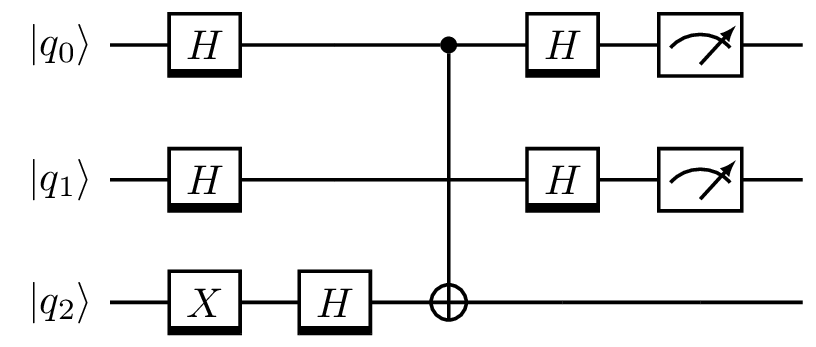

In [4]:
display(p)

## Compile and run the `Program`

By default uses a noisy QVM, meaning that we are running on a quantum simulator with simulated noise. Alternatively, if we have access to real quantum processors (QPUs) via [Quantum Cloud Services (QCS)](https://github.com/rigetti/qcs-paper) we could use actual physical qubits by replacing the string with a lattice name (e.g. `Aspen-4-3Q-D`).

In [5]:
wfn = WavefunctionSimulator().wavefunction(p)
print(f"Here's what the wavefunction, |y x1 x0>, should be after the algorithm:\n{wfn}")

qc = get_qc('3q-noisy-qvm')  # we've also used Aspen-4-3Q-D', 'Aspen-7-3Q-C'
np = qc.compiler.quil_to_native_quil(p)
exe = qc.compiler.native_quil_to_executable(np)
output = qc.run(exe)

Here's what the wavefunction, |y x1 x0>, should be after the algorithm:
(0.7071067812+0j)|001> + (-0.7071067812+0j)|101>


## Collect counts and determine if constant or balanced

In [6]:
balCount = 0
conCount = 0
count00 = 0
count01 = 0
count10 = 0
count11 = 0

for state in output:
    if state[0] == 0 and state[1] == 0:
        conCount += 1
        count00 += 1
    elif state[0] == 1 and state[1] == 0:
        balCount += 1
        count01 += 1
    elif state[0] == 0 and state[1] == 1:
        balCount += 1
        count10 += 1
    else:
        balCount += 1
        count11 += 1

print(f"Number of trials where f is found to be constant: {conCount}")
print(f"Number of trials where f is found to be balanced: {balCount}\n")

if conCount > balCount:
    print("We conclude the function is CONSTANT")
elif conCount < balCount:
    print("We conclude the function is BALANCED")
else:
    print("Inconclusive results")

names = ['|00> (Constant)','|01> (Balanced)', '|10> (Balanced)','|11> (Balanced)']
values = [count00, count01, count10, count11]

Number of trials where f is found to be constant: 98
Number of trials where f is found to be balanced: 902

We conclude the function is BALANCED


## Plot histogram of bitstring outcomes

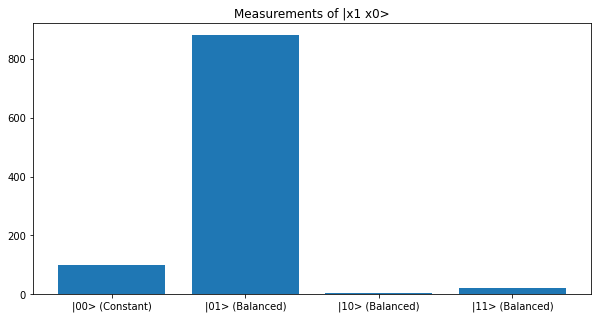

In [7]:
plt.figure(figsize=(10, 5))
plt.bar(names, values)
plt.title("Measurements of |x1 x0>")
plt.show()